# PCA Approach
This file goes through the PCA approach to achieving better performance.

We will also experiment with benefits of treating this data as binary classification and merging results for having the disease (1,2,3,4) vs. not having the disease (0), since it is very unbalanced in terms of samples with each distribution. It may also be beneficial to attempt some approaches that have the goal of maintaing class balances.

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

In [14]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier  # Importing KNN
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd


def run_models(X_train, X_test, y_train, y_test):
    rfmodel = RandomForestClassifier(n_estimators=100)
    gbmodel = GradientBoostingClassifier(n_estimators=100)
    abmodel = AdaBoostClassifier(n_estimators=100)
    etmodel = ExtraTreesClassifier(n_estimators=100)
    lrmodel = LogisticRegression()
    svcmodel = SVC()
    dtmodel = DecisionTreeClassifier()
    knnmodel = KNeighborsClassifier(n_neighbors=5)  # KNN with default number of neighbors = 5
    knnmodel_manhattan = KNeighborsClassifier(n_neighbors=5, metric='manhattan')  # KNN with Manhattan distance
    vcmodel = VotingClassifier(estimators=[('rf', rfmodel), ('gb', gbmodel), ('ab', abmodel), ('et', etmodel), ('lr', lrmodel), ('svc', svcmodel), ('dt', dtmodel)], voting='hard')
    bcmodel = BaggingClassifier(n_estimators=100)

    models = [rfmodel, gbmodel, abmodel, etmodel, lrmodel, svcmodel, dtmodel, knnmodel, knnmodel_manhattan, vcmodel, bcmodel]
    model_names = ['Random Forest', 'Gradient Boosting', 'AdaBoost', 'Extra Trees', 'Logistic Regression', 'SVC', 'Decision Tree', 
                   'K-Nearest Neighbors', 'K-Nearest Neighbors (Manhattan)', 'Voting Classifier', 'Bagging Classifier']
    
    acc_scores = []
    recall_scores = []
    precision_scores = []
    f1_scores = []
    train_acc = []

    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc_scores.append(accuracy_score(y_test, y_pred))
        recall_scores.append(recall_score(y_test, y_pred, average='micro'))
        precision_scores.append(precision_score(y_test, y_pred, average='micro'))
        f1_scores.append(f1_score(y_test, y_pred, average='micro'))
        train_acc.append(accuracy_score(y_train, model.predict(X_train)))
        
    return pd.DataFrame({
        'Model': model_names, 
        'Accuracy': acc_scores, 
        'Recall': recall_scores, 
        'Precision': precision_scores, 
        'F1': f1_scores, 
        'Training Accuracies': train_acc
    })


In [15]:
# Load the dataset
df = pd.read_csv("cleaned_heart_disease.csv")

df_bin = df.copy()
# Convert target variable into binary classification (0 = no disease, 1 = has disease)
df_bin['target'] = df_bin['target'].apply(lambda x: 1 if x > 0 else 0)

# All 5 classes and performance

target
3    329
0    329
2    329
1    329
4    329
Name: count, dtype: int64


c:\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


,Model,Accuracy,Recall,Precision,F1,Training Accuracies
0,Random Forest,0.494565,0.494565,0.494565,0.494565,1.000000
1,Gradient Boosting,0.483696,0.483696,0.483696,0.483696,0.940426
2,AdaBoost,0.461957,0.461957,0.461957,0.461957,0.543465
3,Extra Trees,0.521739,0.521739,0.521739,0.521739,1.000000
4,Logistic Regression,0.472826,0.472826,0.472826,0.472826,0.536778
5,SVC,0.516304,0.516304,0.516304,0.516304,0.748328
6,Decision Tree,0.434783,0.434783,0.434783,0.434783,1.000000
7,K-Nearest Neighbors,0.500000,0.500000,0.500000,0.500000,0.862614
8,K-Nearest Neighbors (Manhattan),0.494565,0.494565,0.494565,0.494565,0.863222
9,Voting Classifier,0.510870,0.510870,0.510870,0.510870,0.966565


Accuracy: 0.47282608695652173
Confusion Matrix:
 [[58 10  3  8  3]
 [ 9 18  9 11  6]
 [ 1  6  4  8  3]
 [ 1  6  6  3  5]
 [ 0  0  1  1  4]]
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.71      0.77        82
           1       0.45      0.34      0.39        53
           2       0.17      0.18      0.18        22
           3       0.10      0.14      0.12        21
           4       0.19      0.67      0.30         6

    accuracy                           0.47       184
   macro avg       0.35      0.41      0.35       184
weighted avg       0.54      0.47      0.50       184



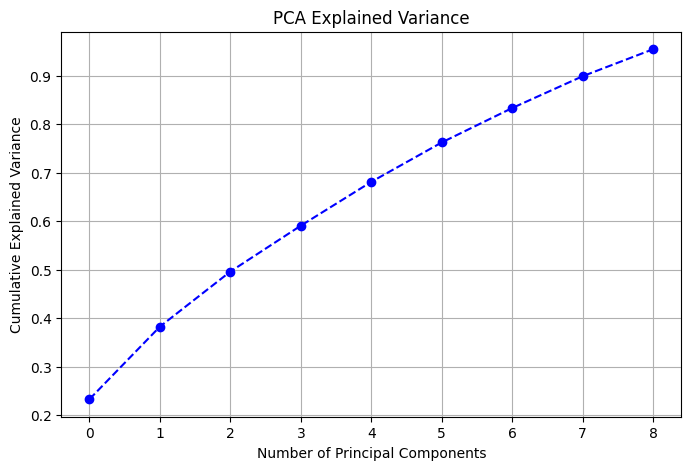

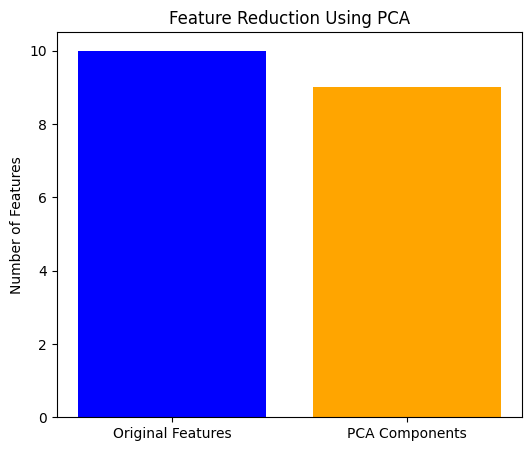

In [16]:
# Split features and target
X = df.drop(columns=['target'])
y = df['target']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance using SMOTE (Synthetic Minority Oversampling Technique)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print(y_train_resampled.value_counts())

display(run_models(X_train_resampled, X_test, y_train_resampled, y_test))

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot explained variance ratio of PCA components
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()


# Bar plot showing number of features before and after PCA
plt.figure(figsize=(6, 5))
plt.bar(['Original Features', 'PCA Components'], [X.shape[1], X_pca.shape[1]], color=['blue', 'orange'])
plt.ylabel('Number of Features')
plt.title('Feature Reduction Using PCA')
plt.show()


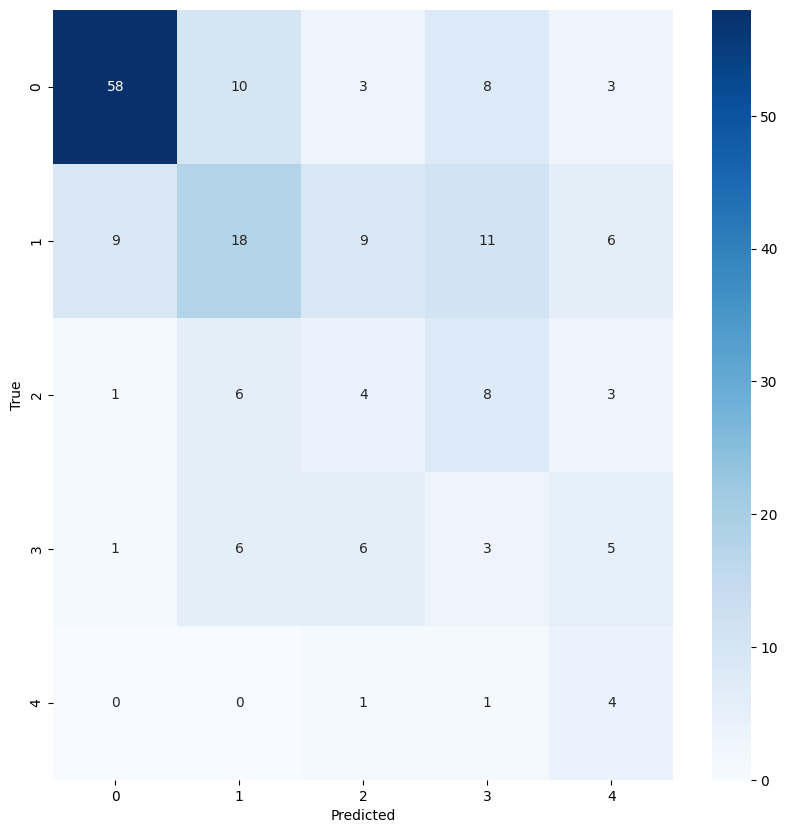

In [17]:
conf_m = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_m, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

# Binary Classes and Performance

c:\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


,Model,Accuracy,Recall,Precision,F1,Training Accuracies
0,Random Forest,0.842391,0.842391,0.842391,0.842391,1.000000
1,Gradient Boosting,0.820652,0.820652,0.820652,0.820652,0.918919
2,AdaBoost,0.804348,0.804348,0.804348,0.804348,0.875921
3,Extra Trees,0.798913,0.798913,0.798913,0.798913,1.000000
4,Logistic Regression,0.804348,0.804348,0.804348,0.804348,0.799754
5,SVC,0.820652,0.820652,0.820652,0.820652,0.842752
6,Decision Tree,0.733696,0.733696,0.733696,0.733696,1.000000
7,K-Nearest Neighbors,0.815217,0.815217,0.815217,0.815217,0.857494
8,K-Nearest Neighbors (Manhattan),0.771739,0.771739,0.771739,0.771739,0.857494
9,Voting Classifier,0.826087,0.826087,0.826087,0.826087,0.934889


Accuracy: 0.8043478260869565
Confusion Matrix:
 [[64 18]
 [18 84]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.78      0.78        82
           1       0.82      0.82      0.82       102

    accuracy                           0.80       184
   macro avg       0.80      0.80      0.80       184
weighted avg       0.80      0.80      0.80       184



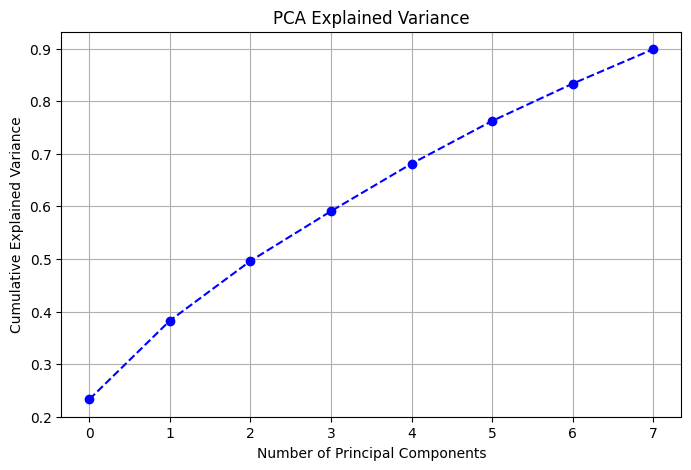

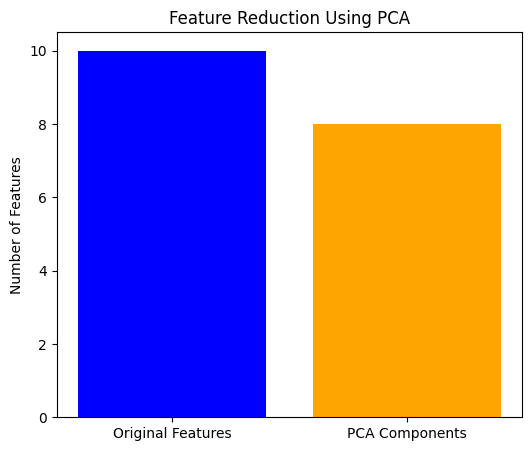

In [25]:
# Split features and target
X = df_bin.drop(columns=['target'])
y = df_bin['target']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.85)  # Retain 85% of variance (optimal finding from grid search below)
X_pca = pca.fit_transform(X_scaled)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance using SMOTE (Synthetic Minority Oversampling Technique)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

display(run_models(X_train_resampled, X_test, y_train_resampled, y_test))

# Train logistic regression model
model = LogisticRegression()
model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plot explained variance ratio of PCA components
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--', color='b')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()

# Distribution of components before and after
plt.figure(figsize=(6, 5))
plt.bar(['Original Features', 'PCA Components'], [X.shape[1], X_pca.shape[1]], color=['blue', 'orange'])
plt.ylabel('Number of Features')
plt.title('Feature Reduction Using PCA')
plt.show()


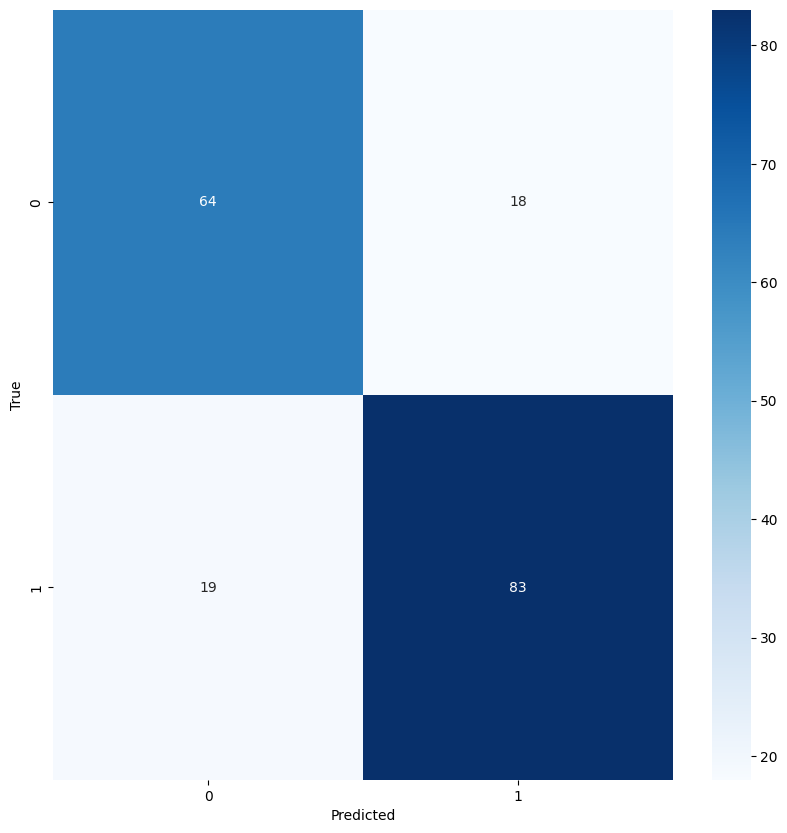

In [19]:
conf_m = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_m, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

# Grid Search to Find optimal for Logistic Regression

Optimal number of PCA components: 0.85
Accuracy: 0.8152173913043478
Confusion Matrix:
 [[65 17]
 [17 85]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.79      0.79        82
           1       0.83      0.83      0.83       102

    accuracy                           0.82       184
   macro avg       0.81      0.81      0.81       184
weighted avg       0.82      0.82      0.82       184



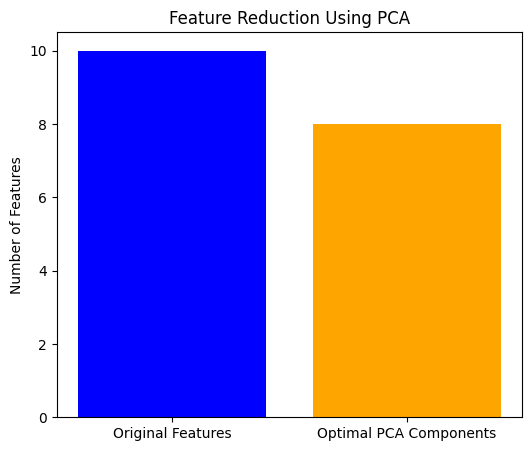

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Split features and target
X = df_bin.drop(columns=['target'])
y = df_bin['target']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define a pipeline with PCA and logistic regression
pipeline = Pipeline([
    ('pca', PCA()),  # PCA step
    ('classifier', LogisticRegression())  # Logistic regression step
])

# Define the parameter grid for PCA
param_grid = {
    'pca__n_components': [0.80, 0.85, 0.90, 0.95, 0.99]  # Variance thresholds to test
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_scaled, y)

# Best PCA component count
best_n_components = grid_search.best_params_['pca__n_components']
print(f"Optimal number of PCA components: {best_n_components}")

# Apply PCA with the best number of components
pca = PCA(n_components=best_n_components)
X_pca = pca.fit_transform(X_scaled)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train logistic regression model with the optimal number of PCA components
model = KNeighborsClassifier()
model.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Distribution of features before and after PCA
plt.figure(figsize=(6, 5))
plt.bar(['Original Features', 'Optimal PCA Components'], [X.shape[1], X_pca.shape[1]], color=['blue', 'orange'])
plt.ylabel('Number of Features')
plt.title('Feature Reduction Using PCA')
plt.show()
